In [1]:
%load_ext autoreload

In [2]:
import os
import sys
import re
from argparse import Namespace

sys.path.append('../src-py/')

os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [21]:
%autoreload

from utils import *
from project_debater_api import *
from mt_bart_v2 import *

In [25]:
import torch
import json

import nltk
import numpy as np
import pandas as pd

from pathlib import Path
from datasets import load_dataset, load_metric, Dataset

from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import BartTokenizer, BartForConditionalGeneration

import matplotlib.pyplot as plt

In [5]:
import pickle

In [6]:
from tabulate import tabulate

In [7]:
import pandas as pd
pd.set_option('display.max_colwidth', None)

In [8]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [9]:
device

device(type='cuda')

In [10]:
ceph_dir = '/home/sile2804/data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation'
local_home_dir = '../data'

In [23]:
def generate_ds_attacks(ds, model, tokenizer, premises_clm, conclusion_clm, gen_kwargs, skip_special_tokens=True, batch_size=16):
    ds = ds.map(lambda x :preprocess_function(x, tokenizer, premises_clm, 'counter', conclusion_clm=conclusion_clm), batched=True)
    ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
    dataloader = torch.utils.data.DataLoader(ds, batch_size=batch_size)
    attacks = generate_counters(model, tokenizer, dataloader, gen_kwargs, skip_special_tokens=skip_special_tokens)
    
    return attacks

def create_predictions_df(reddit_sample_valid_ds, gen_kwargs, premises_clm='masked_premises'):
    
    joint_attacks       = generate_ds_attacks(reddit_sample_valid_ds, join_model, join_model_tokenizer, premises_clm, None, gen_kwargs)
    known_conc_attacks  = generate_ds_attacks(reddit_sample_valid_ds, known_conclusion_model, known_conclusion_tokenizer, premises_clm, 'title', gen_kwargs)
    bart_conc_attacks   = generate_ds_attacks(reddit_sample_valid_ds, known_conclusion_model, known_conclusion_tokenizer, premises_clm, 'bart_conclusion', gen_kwargs)
    arglex_conc_attacks = generate_ds_attacks(reddit_sample_valid_ds, known_conclusion_model, known_conclusion_tokenizer, premises_clm, 'arglex_rank_conclusion', gen_kwargs)
    masked_conc_attacks = generate_ds_attacks(reddit_sample_valid_ds, known_conclusion_model, known_conclusion_tokenizer, premises_clm, None, gen_kwargs)
    
    #update max_gen_length to account to the generated conclusion
    gen_kwargs['max_length'] = gen_kwargs['max_length'] + 30
    joint_conc_baseline_attacks  = generate_ds_attacks(reddit_sample_valid_ds, pred_conclusion_model, pred_conclusion_tokenizer, premises_clm, None, gen_kwargs, skip_special_tokens=False)
    #This model would predict the conclusion and then the counter in one sequence.

    reddit_pred_df = pd.DataFrame(list(zip(
                                           reddit_sample_valid_ds['post_id'],
                                           reddit_sample_valid_ds['title'], 
                                           reddit_sample_valid_ds['conclusion_targets'],
                                           reddit_sample_valid_ds['conclusion_stance'],
                                           reddit_sample_valid_ds['bart_conclusion'], 
                                           reddit_sample_valid_ds['arglex_rank_conclusion'], 
                                           reddit_sample_valid_ds[premises_clm],
                                           reddit_sample_valid_ds['counter'], 
                                           known_conc_attacks, masked_conc_attacks, 
                                           bart_conc_attacks, arglex_conc_attacks, joint_attacks, joint_conc_baseline_attacks)), 
                    columns=['post_id', 'conclusion', 'conclusion_target', 'conclusion_stance', 'bart_conclusion', 'arglex_rank_conclusion', 'premises', 'gt_attack', 'known_conc_attacks', 
                             'masked_conc_attacks', 'bart_conc_attacks', 'arglex_conc_attacks', 'joint_conc_attacks', 'joint_conc_baseline_attacks'])

    reddit_pred_df['argument'] = reddit_pred_df.apply(lambda row: row['conclusion'] + ' : ' + ' '.join(row['premises']), axis=1)
    reddit_pred_df['premises'] = reddit_pred_df['premises'].apply(lambda x: ' '.join(x))

    #process the jointly generated conclusion and counter
    reddit_pred_df['joint_conc_baseline'] = reddit_pred_df['joint_conc_baseline_attacks'].apply (lambda x: x.split('<counter>')[0])
    reddit_pred_df['joint_conc_baseline_attacks'] = reddit_pred_df['joint_conc_baseline_attacks'].apply (lambda x: x.split('<counter>')[1] if '<counter>' in x else x)
    reddit_pred_df['joint_conc_baseline'] = reddit_pred_df['joint_conc_baseline'].apply (lambda x: re.sub('<s>|</s>|<conclusion>|<counter>|<pad>', '', x).strip())
    reddit_pred_df['joint_conc_baseline_attacks'] = reddit_pred_df['joint_conc_baseline_attacks'].apply (lambda x: re.sub('<s>|</s>|<conclusion>|<counter>|<pad>', '', x).strip())

    return reddit_pred_df

def get_evaluation_results(reddit_pred_df, df_path):
    
    #collect references
    df = pd.read_pickle(df_path)
    arg_counters = df.groupby('post_id').agg({
        'counter': lambda x: [' '.join(c) for c in x]
    }).reset_index()

    arg_counters = pd.Series(arg_counters.counter.values, index=arg_counters.post_id).to_dict()

    reddit_pred_df['all_counters'] = reddit_pred_df['post_id'].apply(lambda x: arg_counters[x])
    reddit_pred_df['all_counters'] = reddit_pred_df.all_counters.apply(lambda claims: [c for c in claims if c !=''])
    reddit_pred_df = reddit_pred_df[reddit_pred_df.all_counters.map(len) > 0]

    masked_conc_eval = evaluate_gen_attacks(reddit_pred_df['masked_conc_attacks'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    known_conc_eval  = evaluate_gen_attacks(reddit_pred_df['known_conc_attacks'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    bart_conc_eval   = evaluate_gen_attacks(reddit_pred_df['bart_conc_attacks'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    arglex_conc_eval = evaluate_gen_attacks(reddit_pred_df['arglex_conc_attacks'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    pred_conc_eval   = evaluate_gen_attacks(reddit_pred_df['joint_conc_baseline_attacks'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    joint_conc_eval  = evaluate_gen_attacks(reddit_pred_df['joint_conc_attacks'].tolist(), reddit_pred_df['all_counters'].tolist(), detailed=True)
    
    #Test stance correctness
    filtered_reddit_pred_df = reddit_pred_df[pd.notna(reddit_pred_df.conclusion_target)]
    
    
    #compute the stance of the generated counters towards the conclusion target
    filtered_reddit_pred_df['masked_conc_stances'] = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.masked_conc_attacks.tolist())
    filtered_reddit_pred_df['known_conc_stances']  = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.known_conc_attacks.tolist())
    filtered_reddit_pred_df['bart_conc_stances']   = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.bart_conc_attacks.tolist())
    filtered_reddit_pred_df['arglex_conc_stances'] = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.arglex_conc_attacks.tolist())
    filtered_reddit_pred_df['pred_conc_stances']   = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.joint_conc_baseline_attacks.tolist())
    filtered_reddit_pred_df['joint_conc_stances']  = get_stances(filtered_reddit_pred_df.conclusion_target.tolist(), filtered_reddit_pred_df.joint_conc_attacks.tolist())
    
    #compute the distance between the conclusion stance and the attack stance: the bigger the distance the better...
    masked_conc_eval['stance_score'] = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.masked_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    known_conc_eval['stance_score']  = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.known_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    bart_conc_eval['stance_score']   = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.bart_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    arglex_conc_eval['stance_score'] = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.arglex_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    pred_conc_eval['stance_score']   = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.pred_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)
    joint_conc_eval['stance_score']  = round(np.mean([abs(x[0] - x[1]) for x in zip(filtered_reddit_pred_df.joint_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())]), 2)

    #check if the two stances are contradicotry
    #masked_conc_stance_score2 = round(sum([int(x[0] * x[1] < 0) for x in zip(filtered_reddit_pred_df.masked_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())])/len(filtered_reddit_pred_df), 2)
    #known_conc_stance_score2  = round(sum([int(x[0] * x[1] < 0) for x in zip(filtered_reddit_pred_df.known_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())])/len(filtered_reddit_pred_df), 2)
    #bart_conc_stance_score2   = round(sum([int(x[0] * x[1] < 0) for x in zip(filtered_reddit_pred_df.bart_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())])/len(filtered_reddit_pred_df), 2)
    #pred_conc_stance_score2  = round(sum([int(x[0] * x[1] < 0) for x in zip(filtered_reddit_pred_df.pred_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())])/len(filtered_reddit_pred_df), 2)
    #joint_conc_stance_score2  = round(sum([int(x[0] * x[1] < 0) for x in zip(filtered_reddit_pred_df.joint_conc_stances.tolist(), filtered_reddit_pred_df.conclusion_stance.tolist())])/len(filtered_reddit_pred_df), 2)
    return {'Masked Conclusion': masked_conc_eval,
            'BART Conclusion': bart_conc_eval,
            'ArgLexRank Conclusion': arglex_conc_eval,
            'Joint Prediction (baseline)': pred_conc_eval,
            'Joint Prediction': joint_conc_eval,
            'Known Conclusion': known_conc_eval,
            'preds_df' : reddit_pred_df,
            'stances_df': filtered_reddit_pred_df}


def print_results(pred_df_scores, print_sig=False, sig_lvl=0.05):
    for key in ['Masked Conclusion', 'BART Conclusion', 'ArgLexRank Conclusion', 'Joint Prediction (baseline)', 'Joint Prediction', 'Known Conclusion']:
        for key2 in ['bleu', 'bert-fscore']:
            pred_df_scores[key][key2] = round(pred_df_scores[key][key2], 2)
            
    res_table = tabulate([['Masked Conclusion'] + [pred_df_scores['Masked Conclusion']['bleu'], pred_df_scores['Masked Conclusion']['bert-fscore'], pred_df_scores['Masked Conclusion']['stance_score']],
                    ['BART Conclusion'] + [pred_df_scores['BART Conclusion']['bleu'], pred_df_scores['BART Conclusion']['bert-fscore'], pred_df_scores['BART Conclusion']['stance_score']],
                    ['ArgLexRank Conclusion'] + [pred_df_scores['ArgLexRank Conclusion']['bleu'], pred_df_scores['ArgLexRank Conclusion']['bert-fscore'], pred_df_scores['ArgLexRank Conclusion']['stance_score']],
                    ['Joint Prediction (baseline)'] + [pred_df_scores['Joint Prediction (baseline)']['bleu'], pred_df_scores['Joint Prediction (baseline)']['bert-fscore'], pred_df_scores['Joint Prediction (baseline)']['stance_score']],
                    ['Joint Prediction'] + [pred_df_scores['Joint Prediction']['bleu'], pred_df_scores['Joint Prediction']['bert-fscore'], pred_df_scores['Joint Prediction']['stance_score']],
                    ['Known Conclusion'] + [pred_df_scores['Known Conclusion']['bleu'], pred_df_scores['Known Conclusion']['bert-fscore'], pred_df_scores['Known Conclusion']['stance_score']],
        ], headers=['bleu', 'bert-f1score', 'stance-score (diff)'])
    
    print(res_table)

    if print_sig:
        print('=======')
        #Check significancy:
        print('BART vs baseline (BLEU):', check_sig(pred_df_scores['Joint Prediction']['bleu_scores'], pred_df_scores['Masked Conclusion']['bleu_scores'], alpha=sig_lvl))
        print('BART vs baseline (BERT):', check_sig(pred_df_scores['Joint Prediction']['bert-fscores'], pred_df_scores['Masked Conclusion']['bert-fscores'], alpha=sig_lvl))
        print('-------')
        print('Joint Prediction (baseline) vs baseline (BLEU):', check_sig(pred_df_scores['Joint Prediction (baseline)']['bleu_scores'], pred_df_scores['Masked Conclusion']['bleu_scores'], alpha=sig_lvl))
        print('Joint Prediction (baseline) vs baseline (BERT):', check_sig(pred_df_scores['Joint Prediction (baseline)']['bert-fscores'], pred_df_scores['Masked Conclusion']['bert-fscores'], alpha=sig_lvl))
        print('-------')
        print('Joint Prediction vs baseline (BLEU):', check_sig(pred_df_scores['Joint Prediction']['bleu_scores'], pred_df_scores['Masked Conclusion']['bleu_scores'], alpha=sig_lvl))
        print('Joint Prediction vs baseline (BERT):', check_sig(pred_df_scores['Joint Prediction']['bert-fscores'], pred_df_scores['Masked Conclusion']['bert-fscores'], alpha=sig_lvl))
        print('-------')
        print('Known Conclusion vs baseline (BLEU):', check_sig(pred_df_scores['Known Conclusion']['bleu_scores'], pred_df_scores['Masked Conclusion']['bleu_scores'], alpha=sig_lvl))
        print('Known Conclusion vs baseline (BERT):', check_sig(pred_df_scores['Known Conclusion']['bert-fscores'], pred_df_scores['Masked Conclusion']['bert-fscores'], alpha=sig_lvl))
        
    return res_table

----------------------

## Test Models trained on all data for different levels of conclusion masking:

In [12]:
# data_unique_path = '/reddit_data/conclusion_and_ca_generation/valid_conclusion_all_sample_with_targets_with_arglexrank_conclusions.pkl'
# data_path = '/reddit_data/conclusion_and_ca_generation/valid_conclusion_all.pkl'

data_unique_path = '/reddit_data/conclusion_and_ca_generation/test_conclusion_all_sample_with_targets_with_arglexrank_conclusions.pkl'
data_path = '/reddit_data/conclusion_and_ca_generation/test_concusion_all.pkl'

In [13]:
#ls ../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation

In [14]:
# Loading Reddit models
known_conclusion_model = BartForConditionalGeneration.from_pretrained(local_home_dir  + '/output/valid-ft-all/known-conc-model-2e-05-32').to(device)
known_conclusion_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/valid-ft-all/known-conc-model-2e-05-32')

pred_conclusion_model = BartForConditionalGeneration.from_pretrained(local_home_dir  + '/output/valid-ft-all/pred-conc-model-2e-05-32/').to(device)
pred_conclusion_tokenizer = BartTokenizer.from_pretrained(local_home_dir + '/output/valid-ft-all/pred-conc-model-2e-05-32/')

join_model_tokenizer = BartTokenizer.from_pretrained('../data/output/valid-ft-all/mt-model-5e-05-32/checkpoint-7500/')
join_model  = BartModelV2.from_pretrained('../data/output/valid-ft-all/mt-model-5e-05-32/checkpoint-7500/', compute_dynamic_weights=True, conc_decoder=True).to(device)

In [15]:
valid_df = pd.read_pickle(ceph_dir + data_unique_path)

In [ ]:
gen_kwargs = {
    "do_sample": False, 
    "max_length":100,
    "num_beams":10
}

#Create a dataset
unique_valid_posts = valid_df.drop_duplicates('post_id')
print('Testing on {} posts'.format(len(unique_valid_posts)))
valid_ds = Dataset.from_pandas(unique_valid_posts)
valid_ds = valid_ds.flatten_indices()

#generate predictions
reddit_pred_df = create_predictions_df(valid_ds, gen_kwargs, premises_clm='post')
reddit_pred_df.to_pickle('../data/output/reddit_pred_test_df.pkl')

Testing on 1901 posts


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

ProConClient:   0%|          | 0/20 [05:27<?, ?it/s]


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

ddd ['as well, overdose due to drugs cut with unknown and dangerous substances and the spread of diseases through sharing needles is an epidemic that is a further tax on our healthcare system. by manufacturing these drugs and having them available for public consumption we could eliminate the spread of diseases, and prevent overdoses by controlling the whole process of drug addiction.', 'as a immigrant who spent thousands of dollars and many hours working to come legally i find it highly irritating that they re being defended for breaking a law. this political agenda people use only makes it worse for them.', 'sorry if this sounds sexist, but women and men are different, and i believe it is valid to be more or less jealous of people based on their character. it also seems to me that men are very strongly conditioned to be jealous of other men, while the same conditioning does not really happen for jealousy of women now, this can very well be because whatever forces gave rise to this co

In [27]:
#reddit_pred_df = pd.read_pickle('../data/output/reddit_pred_test_df.pkl')

In [40]:
print('Number of samples is {} with average similarity to conclusion = {}'.format(len(reddit_pred_df), round(reddit_pred_df['max_sim_to_conclusion'].mean(), 2)))
pred_df_scores = get_evaluation_results(reddit_pred_df, ceph_dir + data_path)
print_results(pred_df_scores)

Number of samples is 1901 with average similarity to conclusion = 0.59


ProConClient: 100%|██████████| 1901/1901 [00:43<00:00, 44.11it/s]

ProConClient: 100%|██████████| 1901/1901 [00:24<00:00, 77.19it/s]

ProConClient:   0%|          | 0/1901 [00:00<?, ?it/s]

ProConClient:  26%|██▋       | 500/1901 [00:06<00:16, 83.10it/s]

ProConClient:  53%|█████▎    | 1000/1901 [00:12<00:10, 82.99it/s]

ProConClient: 100%|██████████| 1901/1901 [00:48<00:00, 39.43it/s]


ProConClient:  53%|█████▎    | 1000/1901 [00:12<00:10, 85.57it/s]

ProConClient: 100%|██████████| 1901/1901 [00:24<00:00, 77.26it/s]

                               bleu    bert-f1score    stance-score (diff)
---------------------------  ------  --------------  ---------------------
Masked Conclusion              0.24            0.17                   0.77
BART Conclusion                0.27            0.21                   0.7
ArgLexRank Conclusion          0.21            0.16                   0.74
Joint Prediction (baseline)    0.25            0.19                   0.75
Joint Prediction               0.25            0.17                   0.76
Known Conclusion               0.31            0.22                   0.61


'                               bleu    bert-f1score    stance-score (diff)\n---------------------------  ------  --------------  ---------------------\nMasked Conclusion              0.24            0.17                   0.77\nBART Conclusion                0.27            0.21                   0.7\nArgLexRank Conclusion          0.21            0.16                   0.74\nJoint Prediction (baseline)    0.25            0.19                   0.75\nJoint Prediction               0.25            0.17                   0.76\nKnown Conclusion               0.31            0.22                   0.61'

#### Analyze effectiveness for different levels of similarity to conclusion:

In [ ]:
reddit_pred_df = split_dataframe_per_conc_similarity(reddit_pred_df)

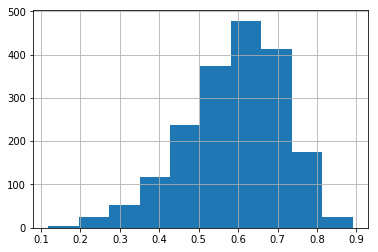

In [33]:
reddit_pred_df['max_sim_to_conclusion'].hist()

In [39]:
#Analyze scores on different levels of similarity to conclusion
sorted_df  = reddit_pred_df.sort_values('max_sim_to_conclusion')
num_chunks = 5
chunk_size = int(len(sorted_df)/num_chunks)
all_pred_scores = []
for i in range(0, num_chunks) :
    reddit_pred_df_chunk = sorted_df[i*chunk_size: (i+1) * chunk_size].copy()
    print('Number of samples is {} with average similarity to conclusion = {}'.format(len(reddit_pred_df_chunk), round(reddit_pred_df_chunk['max_sim_to_conclusion'].mean(), 2)))
    pred_df_scores = get_evaluation_results(reddit_pred_df_chunk, ceph_dir + data_path)
    print_results(pred_df_scores)
    all_pred_scores.append(pred_df_scores)

Number of samples is 380 with average similarity to conclusion = 0.4
Number of samples is 380 with average similarity to conclusion = 0.53
Number of samples is 380 with average similarity to conclusion = 0.6
Number of samples is 380 with average similarity to conclusion = 0.67
Number of samples is 380 with average similarity to conclusion = 0.75


In [ ]:
pickle.dump(all_pred_scores[-1], open('../data/output/test_eval_results.pkl', 'wb'))

In [34]:
for s in all_pred_scores:
    x = print_results(s)

                               bleu    bert-f1score    stance-score (diff)
---------------------------  ------  --------------  ---------------------
Masked Conclusion              0.21            0.14                   0.78
BART Conclusion                0.23            0.2                    0.72
ArgLexRank Conclusion          0.2             0.14                   0.79
Joint Prediction (baseline)    0.22            0.17                   0.72
Joint Prediction               0.21            0.15                   0.77
Known Conclusion               0.29            0.21                   0.62
                               bleu    bert-f1score    stance-score (diff)
---------------------------  ------  --------------  ---------------------
Masked Conclusion              0.25            0.16                   0.8
BART Conclusion                0.25            0.21                   0.74
ArgLexRank Conclusion          0.21            0.15                   0.77
Joint Prediction (baseline

#### Analyze effectiveness for different levels of argument length:

In [37]:
reddit_pred_df['arg_len'] = reddit_pred_df.premises.apply(lambda x: len(nltk.word_tokenize(x)))

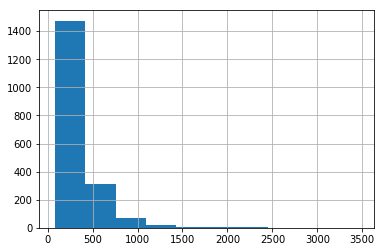

In [38]:
reddit_pred_df['arg_len'].hist()

In [ ]:
#Analyze scores on different levels of argument length
sorted_df  = reddit_pred_df.sort_values('arg_len')
num_chunks = 5
chunk_size = int(len(sorted_df)/num_chunks)
all_pred_scores_per_len = []
for i in range(1, num_chunks) :
    reddit_pred_df_chunk = sorted_df[i*chunk_size: (i+1) * chunk_size].copy()
    print('Number of samples is {} with average similarity to conclusion = {}'.format(len(reddit_pred_df_chunk), round(reddit_pred_df_chunk['arg_len'].mean(), 2)))
    pred_df_scores = get_evaluation_results(reddit_pred_df_chunk, ceph_dir + data_path)
    print_results(pred_df_scores)
    all_pred_scores_per_len.append(pred_df_scores)

In [41]:
for s in all_pred_scores_per_len:
    print_results(s)

ProConClient: 100%|██████████| 1901/1901 [00:34<00:00, 77.26it/s]

### Run experiments by removing premises that are similar to the conclusion:

In [17]:
levels_of_masking = [1.0, 0.75, 0.6, 0.5]

gen_kwargs = {
    "do_sample": False, 
    "max_length":100,
    "num_beams":10
}

all_pred_scores = []
for lvl in levels_of_masking:
    masked_clm = '{}_perc_masked_premises'.format(lvl*10)
    valid_df = remove_similar_sents(valid_df, threshold=lvl, masked_clm = masked_clm)

    #Create a dataset
    unique_valid_posts = valid_df.drop_duplicates('post_id')
    valid_ds = Dataset.from_pandas(unique_valid_posts)
    #If we want to take a small sample..
    #valid_ds = valid_ds.train_test_split(0.5)
    #valid_ds = valid_ds['test']
    valid_ds = valid_ds.flatten_indices()

    #generate predictions
    reddit_pred_df = create_predictions_df(valid_ds, gen_kwargs, premises_clm=masked_clm)
    reddit_pred_df.to_pickle('../data/output/reddit_pred_df_{}.pkl'.format(masked_clm))
    
    pred_df_scores = get_evaluation_results(reddit_pred_df, ceph_dir + data_path)
    print_results(pred_df_scores)
    all_pred_scores.append(pred_df_scores)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

ProConClient: 100%|██████████| 1499/1499 [00:26<00:00, 56.92it/s]

                                 bleu    bert-f1score    stance-score (diff)
---------------------------  --------  --------------  ---------------------
Masked Conclusion            0.133543        0.117534                   0.74
BART Conclusion              0.136626        0.166914                   0.89
ArgLexRank Conclusion        0.127403        0.120435                   0.77
Joint Prediction (baseline)  0.143528        0.140205                   0.81
Joint Prediction             0.152893        0.119865                   0.73
Known Conclusion             0.196081        0.167839                   0.87
Distribution is not normal, so using wilcoxon
BART vs baseline (BLEU): True
Distribution is not normal, so using wilcoxon
BART vs baseline (BERT): False
-------
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BLEU): False
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BERT): True
-------
Distribution is 

ProConClient: 100%|██████████| 1499/1499 [00:34<00:00, 43.94it/s]


  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

ProConClient: 100%|██████████| 1499/1499 [00:22<00:00, 69.14it/s]

                                 bleu    bert-f1score    stance-score (diff)
---------------------------  --------  --------------  ---------------------
Masked Conclusion            0.126556        0.109075                   0.76
BART Conclusion              0.134031        0.167167                   0.89
ArgLexRank Conclusion        0.127082        0.11991                    0.78
Joint Prediction (baseline)  0.139894        0.129912                   0.82
Joint Prediction             0.139065        0.109321                   0.72
Known Conclusion             0.19497         0.167571                   0.88
Distribution is not normal, so using wilcoxon
BART vs baseline (BLEU): True
Distribution is not normal, so using wilcoxon
BART vs baseline (BERT): False
-------
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BLEU): False
Distribution is not normal, so using wilcoxon
Joint Prediction (baseline) vs baseline (BERT): True
-------
Distribution is 


ProConClient: 100%|██████████| 1499/1499 [00:40<00:00, 69.14it/s]